In [1]:
using CarrierCapture
using Plots, LaTeXStrings
using DataFrames

┌ Info: Recompiling stale cache file /Users/landau/.julia/compiled/v1.2/CarrierCapture/RUt0q.ji for CarrierCapture [05287f9a-33ab-11e9-31fb-01c88c8bf238]
└ @ Base loading.jl:1240


# Potentials

In [2]:
Qmin = -25
Qmax = 35
NQ = 3000
Q = range(Qmin, stop=Qmax, length=NQ)

-25.0:0.020006668889629875:35.0

In [3]:
# pot1
nev = 30
name = "SnII+e+h"

pot1 = potential(); pot1.name = name
pot1.Q0 = 0; pot1.E0 = 1.46
pot1.nev = nev
pot1.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0288945775003
fit_pot!(pot1, Q; params = params)
# pot1.func = x -> harmonic(x, 0.0288945775003; E₀ = pot1.E0, Q₀ = pot1.Q0)
# pot1.Q = Q
# pot1.E = pot1.func.(Q)


# pot2
nev = 40
name = "SnIII+h"

pot2 = potential(); pot2.name = name
pot2.Q0 = 1.90291674728; pot2.E0 = 0.585005
pot2.nev = nev
pot2.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0281812646475
fit_pot!(pot2, Q; params = params)
# pot2.func = x -> harmonic(x, 0.1281812646475; E₀ = pot2.E0, Q₀ = pot2.Q0)
# pot2.Q = Q
# pot2.E = pot2.func.(Q)


# pot3
nev = 30
hw = 0.0288945775003
name = "SnII"

pot3 = potential(); pot3.name = name
pot3.Q0 = 0; pot3.E0 = 0
pot3.nev = nev
pot3.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0288945775003

fit_pot!(pot3, Q; params = params)
# pot3.func = x -> harmonic(x, 0.0288945775003; E₀ = pot3.E0, Q₀ = pot3.Q0)
# pot3.Q = Q
# pot3.E = pot3.func.(Q)


solve_pot!(pot1)
solve_pot!(pot2)
solve_pot!(pot3)
# 

Potential fitting: SnII+e+h
========harmonic=========

Potential fitting: SnIII+h
========harmonic=========

Potential fitting: SnII
========harmonic=========



([0.014449607416044974, 0.043343823112772586, 0.0722280379409027, 0.10110224670006342, 0.12996644418086822, 0.15882062516495316, 0.18766478442475507, 0.2164989167237059, 0.24532301681605048, 0.2741370794469343  …  0.5904277837918395, 0.6191209836363396, 0.6478040768608645, 0.6764770580795447, 0.7051399218969961, 0.7337926629081999, 0.7624352756985882, 0.7910677548438657, 0.819690094910132, 0.8483022904537776], [-1.1854726826286944e-17 -8.277858386598439e-17 … 2.1377533137862838e-16 -4.0213538449565594e-16; -1.4723779432299577e-17 8.34093411855365e-18 … -5.575426723674201e-16 4.990899499644444e-16; … ; 5.169385503214281e-17 1.9039532388682703e-18 … -3.6000763065333543e-16 3.249085066642278e-16; 1.170667907864963e-16 8.783528662931823e-17 … -1.0074485192465287e-16 -6.761610040810727e-17])

### Capture barriers

In [4]:
Qx, Ex = find_crossing(pot1, pot2)
println("Electron capture barrier: $(Ex-pot1.E0) eV")
Qx, Ex = find_crossing(pot2, pot3)
println("Hole capture barrier: $(Ex-pot2.E0) eV")

Electron capture barrier: 0.2244086500961966 eV
Hole capture barrier: 0.03233164063109362 eV


### Potentials and associated wave functions 

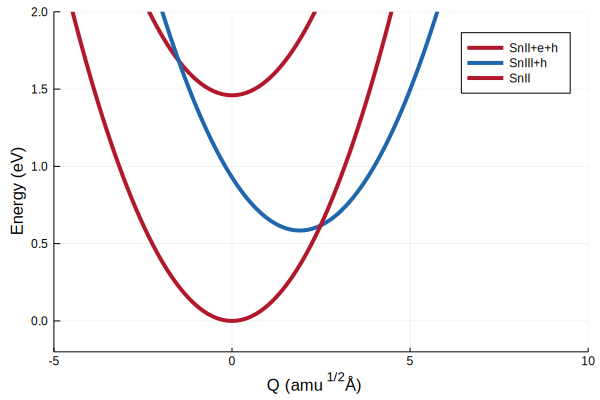

In [5]:
plt = plot()
Plotter.plot_pot!(pot1; lplt_wf = false, plt = plt, color = "#b2182b")
Plotter.plot_pot!(pot2; lplt_wf = false, plt = plt, color = "#2166ac")
Plotter.plot_pot!(pot3; lplt_wf = false, plt = plt, color = "#b2182b")
xlims!((-5, 10))
ylims!((-0.2, 2))

# Capture coefficient

In [6]:
Cmin = 1E-20
Cmax = 1E-5
invTmin = 1
invTmax = 13
Tmin = 10
Tmax = 800
NT = 100
Volume = 1.28463E-21
cut_off = 0.25
σ = 0.0075
temperature = range(Tmin, stop=Tmax, length=NT)

10.0:7.97979797979798:800.0

## Electron capture

In [7]:
W = 0.205 # e-ph coupling
g = 1 # degeneracy

# build a configuration coordinate for the electron capture
cc_e = conf_coord(pot1, pot2)
cc_e.W = W
cc_e.g = g
calc_overlap!(cc_e; cut_off = cut_off, σ = σ)
calc_capt_coeff!(cc_e, Volume, temperature)

10.0:7.97979797979798:800.0

## Hole capture

In [8]:
W = 0.178 # e-ph coupling
g = 1 # degeneracy

# build a configuration coordinate for the electron capture
cc_h = conf_coord(pot2, pot3)
cc_h.W = W
cc_h.g = g
calc_overlap!(cc_h; cut_off = cut_off, σ = σ)
calc_capt_coeff!(cc_h, Volume, temperature)

10.0:7.97979797979798:800.0

In [ ]:
plt = plot()

Plotter.plot_cc!(cc_e; plt=plt, label="electron capture")
Plotter.plot_cc!(cc_h; plt=plt, label="hole capture")


xlims!(invTmin, invTmax)
ylims!(1E-12, 1E-6)

# plot!(1000 ./ cc_e.temperature, log10.(cc_e.capt_coeff), lw=4, label="electron capture")
# plot!(1000 ./ cc_h.temperature, log10.(cc_h.capt_coeff), lw=4, label="hole capture")

# xaxis!(L"\ 1000\/T (K^{-1}) \ (^{}$$")
# yaxis!(L"C (cm^{3}\/s) \ (^{}$$",)

# xlims!(invTmin, invTmax)
# ylims!(-12, -6)
# yticks!([-6, -8, -10, -12], ["10^{-6}", "10^{-8}", "10^{-10}", "10^{-12}"])
